In [1]:
import numpy as np
import pandas as pd 
import os

In [2]:
import gc
import shap
import glob
import seaborn as sns
import pyarrow.parquet as pq
from datetime import timedelta
from collections import Counter
import matplotlib.pyplot as plt
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score ,log_loss, f1_score, recall_score

In [3]:
def stats(data:pd.DataFrame) -> pd.DataFrame:
    maxx = []
    minn = []
    for i in data.columns:
        maxx.append(data[i].value_counts().max())
        minn.append(data[i].value_counts().min())

    return pd.DataFrame(
        {'nunique': data.nunique(),
         'len': len(data),
         'types':data.dtypes,
         'Nulls' : data.isna().sum(),
         "Value counts Max": maxx,
         'Value counts Min':minn 
        },
        columns = ['nunique', 'len','types','Nulls'
                   ,"Value counts Max",'Value counts Min']).\
        sort_values(by ='nunique',ascending = False)


def plot_shap_for_observation(N:int, shap_values: shap.Explanation) -> None:
    val = shap_values[N].values.sum() + shap_values[N].base_values.sum()
    prob = np.exp(val)/(1+np.exp(val))
    
    shap.plots.waterfall(shap_values[N],show = False)
    plt.title(f'N = {N} \n probability : {prob}')
    plt.show()

# load data and EDA

## load train data

In [4]:
train_files = glob.glob('/kaggle/input/neo-bank-non-sub-churn-prediction/train_*.parquet')

# Read all the files and concatenate them
df_train = pd.concat([pq.read_table(file).to_pandas() for file in train_files])
df_train = df_train.sort_values(by=['customer_id','date'])
df_train.head()

,Id,customer_id,interest_rate,name,country,date_of_birth,address,date,atm_transfer_in,atm_transfer_out,...,crypto_in_volume,crypto_out_volume,complaints,touchpoints,csat_scores,tenure,from_competitor,job,churn_due_to_fraud,model_predicted_fraud
0,1,1,3.5,Yolanda Parker,Lithuania,1954-07-10,"1929 Erin Lights Suite 709\nLake Michaelburgh,...",2008-01-17,0,0,...,393.145010,220.900654,0,[],"{'appointment': None, 'email': None, 'phone': ...",0,False,Amenity horticulturist,False,False
1,6,1,3.5,Yolanda Parker,Lithuania,1954-07-10,"1929 Erin Lights Suite 709\nLake Michaelburgh,...",2008-01-18,0,0,...,390.005729,221.147296,0,[],"{'appointment': None, 'email': None, 'phone': ...",1,False,Amenity horticulturist,False,False
2,16,1,3.5,Yolanda Parker,Lithuania,1954-07-10,"1929 Erin Lights Suite 709\nLake Michaelburgh,...",2008-01-19,0,0,...,393.209108,260.510535,0,[],"{'appointment': None, 'email': None, 'phone': ...",2,False,Amenity horticulturist,False,False
3,31,1,3.5,Yolanda Parker,Lithuania,1954-07-10,"1929 Erin Lights Suite 709\nLake Michaelburgh,...",2008-01-20,0,0,...,394.078294,203.214128,0,[],"{'appointment': None, 'email': None, 'phone': ...",3,False,Amenity horticulturist,False,False
4,50,1,3.5,Yolanda Parker,Lithuania,1954-07-10,"1929 Erin Lights Suite 709\nLake Michaelburgh,...",2008-01-21,0,0,...,395.174604,207.894467,0,"[whatsapp, email, email]","{'appointment': None, 'email': None, 'phone': ...",4,False,Amenity horticulturist,False,False


In [5]:
stats(df_train.select_dtypes(exclude = ['object']))

,nunique,len,types,Nulls,Value counts Max,Value counts Min
Id,3926058,3926058,int64,0,1,1
crypto_out_volume,3648444,3926058,float64,0,84415,1
bank_transfer_in_volume,3648444,3926058,float64,0,84415,1
crypto_in_volume,3648444,3926058,float64,0,84415,1
bank_transfer_out_volume,3648444,3926058,float64,0,84415,1
customer_id,106179,3926058,int64,0,362,1
bank_transfer_in,24245,3926058,int64,0,1199629,1
bank_transfer_out,15703,3926058,int64,0,2041907,1
date,5828,3926058,datetime64[ns],0,1593,5
tenure,5303,3926058,int64,0,96601,1


In [6]:
df_train.select_dtypes('object').head()

,name,country,date_of_birth,address,touchpoints,csat_scores,job
0,Yolanda Parker,Lithuania,1954-07-10,"1929 Erin Lights Suite 709\nLake Michaelburgh,...",[],"{'appointment': None, 'email': None, 'phone': ...",Amenity horticulturist
1,Yolanda Parker,Lithuania,1954-07-10,"1929 Erin Lights Suite 709\nLake Michaelburgh,...",[],"{'appointment': None, 'email': None, 'phone': ...",Amenity horticulturist
2,Yolanda Parker,Lithuania,1954-07-10,"1929 Erin Lights Suite 709\nLake Michaelburgh,...",[],"{'appointment': None, 'email': None, 'phone': ...",Amenity horticulturist
3,Yolanda Parker,Lithuania,1954-07-10,"1929 Erin Lights Suite 709\nLake Michaelburgh,...",[],"{'appointment': None, 'email': None, 'phone': ...",Amenity horticulturist
4,Yolanda Parker,Lithuania,1954-07-10,"1929 Erin Lights Suite 709\nLake Michaelburgh,...","[whatsapp, email, email]","{'appointment': None, 'email': None, 'phone': ...",Amenity horticulturist


In [7]:
# no job/country/address change in train
for i in ['country','address','job']:
    print(df_train.groupby('customer_id')[i].nunique().value_counts())

country
1    106179
Name: count, dtype: int64
address
1    106179
Name: count, dtype: int64
job
1    106179
Name: count, dtype: int64


## load test data

In [8]:
df_test = pq.read_table('/kaggle/input/neo-bank-non-sub-churn-prediction/test.parquet').to_pandas() 
df_test = df_test.sort_values(by=['customer_id','date'])
df_test.head()

,Id,customer_id,interest_rate,name,country,date_of_birth,address,date,atm_transfer_in,atm_transfer_out,...,crypto_out_volume,complaints,touchpoints,csat_scores,tenure,from_competitor,job,churn_due_to_fraud,Usage,model_predicted_fraud
1097087,7284407,1,0.0,Yolanda Parker,Lithuania,1954-07-10,"1929 Erin Lights Suite 709\nLake Michaelburgh,...",2026-02-27,0,0,...,213.615319,0,[],"{'appointment': None, 'email': None, 'phone': ...",5398,False,Amenity horticulturist,False,Public,False
1040227,7227547,2,2.8,Bonnie Carr,Greece,1947-05-27,00867 Dominguez Camp Apt. 575\nPort Josephland...,2026-01-03,0,0,...,34.881290,0,[],"{'appointment': None, 'email': None, 'phone': ...",887,False,Exhibition designer,False,Public,False
392455,6579775,3,0.0,Michael Mcknight,Romania,2002-11-09,"36495 Travis Ranch Apt. 055\nJustinmouth, CO 7...",2024-10-27,0,0,...,1163.469651,0,[],"{'appointment': None, 'email': None, 'phone': ...",5217,False,"Engineer, broadcasting (operations)",False,Public,False
555437,6742757,4,3.2,Sharon Howard,Switzerland,1973-09-16,"4660 Wilson Streets Apt. 764\nSouth Amyside, P...",2025-02-22,0,0,...,119.017834,0,[],"{'appointment': None, 'email': None, 'phone': ...",448,False,Hydrographic surveyor,False,Public,False
38410,6225730,5,3.0,Emily Solis,Netherlands,2006-06-30,"664 Brown Rapid\nBrianburgh, MN 10337 Netherlands",2024-02-01,0,0,...,63.071141,0,"[phone, phone]","{'appointment': None, 'email': None, 'phone': ...",5859,False,Occupational hygienist,False,Private,False


In [9]:
# no job/country/address change  in test
for i in ['country','address','job','Usage']:
    print(df_test.groupby('customer_id')[i].nunique().value_counts())

country
1    165155
Name: count, dtype: int64
address
1    165155
Name: count, dtype: int64
job
1    165155
Name: count, dtype: int64
Usage
1    165090
2        65
Name: count, dtype: int64


In [10]:
df_test.head()

,Id,customer_id,interest_rate,name,country,date_of_birth,address,date,atm_transfer_in,atm_transfer_out,...,crypto_out_volume,complaints,touchpoints,csat_scores,tenure,from_competitor,job,churn_due_to_fraud,Usage,model_predicted_fraud
1097087,7284407,1,0.0,Yolanda Parker,Lithuania,1954-07-10,"1929 Erin Lights Suite 709\nLake Michaelburgh,...",2026-02-27,0,0,...,213.615319,0,[],"{'appointment': None, 'email': None, 'phone': ...",5398,False,Amenity horticulturist,False,Public,False
1040227,7227547,2,2.8,Bonnie Carr,Greece,1947-05-27,00867 Dominguez Camp Apt. 575\nPort Josephland...,2026-01-03,0,0,...,34.881290,0,[],"{'appointment': None, 'email': None, 'phone': ...",887,False,Exhibition designer,False,Public,False
392455,6579775,3,0.0,Michael Mcknight,Romania,2002-11-09,"36495 Travis Ranch Apt. 055\nJustinmouth, CO 7...",2024-10-27,0,0,...,1163.469651,0,[],"{'appointment': None, 'email': None, 'phone': ...",5217,False,"Engineer, broadcasting (operations)",False,Public,False
555437,6742757,4,3.2,Sharon Howard,Switzerland,1973-09-16,"4660 Wilson Streets Apt. 764\nSouth Amyside, P...",2025-02-22,0,0,...,119.017834,0,[],"{'appointment': None, 'email': None, 'phone': ...",448,False,Hydrographic surveyor,False,Public,False
38410,6225730,5,3.0,Emily Solis,Netherlands,2006-06-30,"664 Brown Rapid\nBrianburgh, MN 10337 Netherlands",2024-02-01,0,0,...,63.071141,0,"[phone, phone]","{'appointment': None, 'email': None, 'phone': ...",5859,False,Occupational hygienist,False,Private,False


In [11]:
stats(df_test.select_dtypes(exclude = ['object']))

,nunique,len,types,Nulls,Value counts Max,Value counts Min
Id,1360472,1360472,int64,0,1,1
crypto_out_volume,1358289,1360472,float64,0,2,1
bank_transfer_in_volume,1358289,1360472,float64,0,2,1
crypto_in_volume,1358289,1360472,float64,0,2,1
bank_transfer_out_volume,1358289,1360472,float64,0,2,1
customer_id,165155,1360472,int64,0,84,1
bank_transfer_in,22010,1360472,int64,0,521251,1
bank_transfer_out,16734,1360472,int64,0,699179,1
tenure,4831,1360472,int64,0,54198,1
date,1096,1360472,datetime64[ns],0,1643,17


In [12]:
df_test.select_dtypes('object').head()

,name,country,date_of_birth,address,touchpoints,csat_scores,job,Usage
1097087,Yolanda Parker,Lithuania,1954-07-10,"1929 Erin Lights Suite 709\nLake Michaelburgh,...",[],"{'appointment': None, 'email': None, 'phone': ...",Amenity horticulturist,Public
1040227,Bonnie Carr,Greece,1947-05-27,00867 Dominguez Camp Apt. 575\nPort Josephland...,[],"{'appointment': None, 'email': None, 'phone': ...",Exhibition designer,Public
392455,Michael Mcknight,Romania,2002-11-09,"36495 Travis Ranch Apt. 055\nJustinmouth, CO 7...",[],"{'appointment': None, 'email': None, 'phone': ...","Engineer, broadcasting (operations)",Public
555437,Sharon Howard,Switzerland,1973-09-16,"4660 Wilson Streets Apt. 764\nSouth Amyside, P...",[],"{'appointment': None, 'email': None, 'phone': ...",Hydrographic surveyor,Public
38410,Emily Solis,Netherlands,2006-06-30,"664 Brown Rapid\nBrianburgh, MN 10337 Netherlands","[phone, phone]","{'appointment': None, 'email': None, 'phone': ...",Occupational hygienist,Private


## check time spans train

In [13]:
df_train['year'] = df_train.date.dt.year
df_train['month'] = df_train.date.dt.month

periods = df_train.groupby('customer_id').agg({'year':['min','max']}).droplevel(0, axis=1) 
periods['diff'] = periods['max']-periods['min']
periods.head()

,min,max,diff
customer_id,,,
1,2008,2022,14
2,2008,2010,2
3,2008,2022,14
4,2008,2009,1
5,2008,2023,15


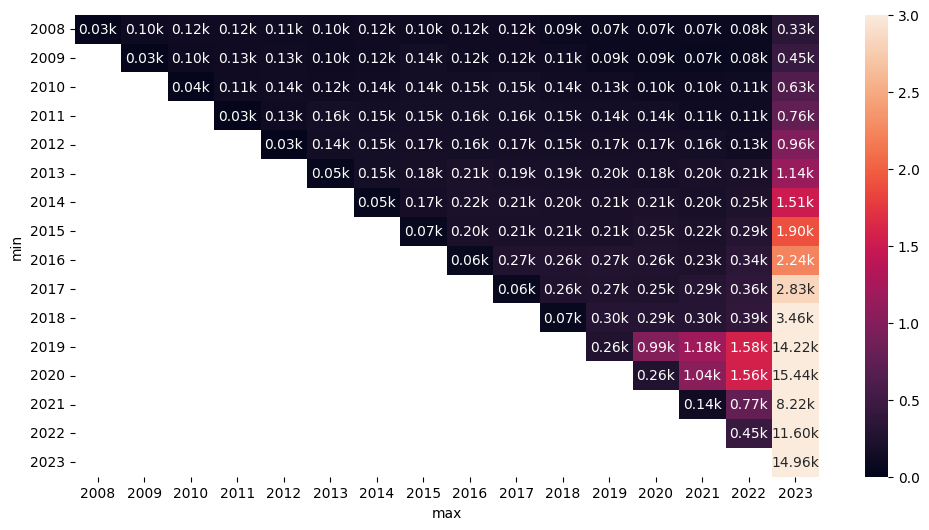

In [14]:

trans_matrix = periods.groupby(['min', 'max']).count().unstack()
trans_matrix.columns = trans_matrix.columns.droplevel()

fig, ax = plt.subplots(figsize=(12,6))
ax = sns.heatmap(trans_matrix/1000,vmin=0,vmax=3,annot=True,fmt='.2f')
for t in ax.texts: t.set_text(t.get_text() + "k")
plt.show()

### check time spans test

In [15]:
df_test['year'] = df_test.date.dt.year
df_test['month'] = df_test.date.dt.month

test_periods = df_test.groupby('customer_id').agg({'year':['min','max']}).droplevel(0, axis=1) 
test_periods['diff'] = test_periods['max']-test_periods['min']
test_periods.head()

,min,max,diff
customer_id,,,
1,2026,2026,0
2,2026,2026,0
3,2024,2024,0
4,2025,2025,0
5,2024,2025,1


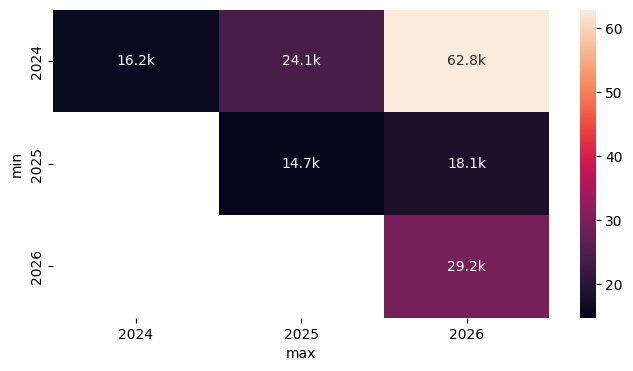

In [16]:
trans_matrix = test_periods.groupby(['min', 'max']).count().unstack()
trans_matrix.columns = trans_matrix.columns.droplevel()

fig, ax = plt.subplots(figsize=(8,4))
ax = sns.heatmap(trans_matrix/1000,annot=True,fmt='.1f')
for t in ax.texts: t.set_text(t.get_text() + "k")
plt.show()


# train test distribution

In [17]:
real_activity_columns = ['atm_transfer_in',
       'atm_transfer_out', 'bank_transfer_in', 'bank_transfer_out',
       'crypto_in', 'crypto_out']

real_activity_volumn_columns = ['bank_transfer_in_volume',
       'bank_transfer_out_volume', 'crypto_in_volume', 'crypto_out_volume']


def add_columns_for_distributions(data:pd.DataFrame) -> pd.DataFrame:
    data['prev_activity_in_days'] = data.groupby('customer_id')['date'].diff().dt.days
    data['first_activity'] = data.groupby('customer_id')['date'].transform('min')
    
    data['last_activity'] = data.groupby('customer_id')['date'].transform('max')
    data['days_between_first_and_last_activity'] = (data['last_activity']-
                                                        data['first_activity']).dt.days

    data['activities_count_today'] = data[real_activity_columns+
                                        real_activity_volumn_columns].gt(0).sum(axis=1)

    return data


In [18]:
df_train = add_columns_for_distributions(df_train)
df_test = add_columns_for_distributions(df_test)

In [19]:
train_stats = df_train.groupby('customer_id', as_index=False)\
           .agg(days_between_last_first=('days_between_first_and_last_activity','mean'),
                 prev_activity_in_days_mean=('prev_activity_in_days','mean'),
                real_activity_num_mean=('activities_count_today','count'),
                 num_activities = ('Id','count'))

test_stats = df_test.groupby('customer_id', as_index=False)\
           .agg(days_between_last_first=('days_between_first_and_last_activity','mean'),
                 prev_activity_in_days_mean=('prev_activity_in_days','mean'),
                real_activity_num_mean=('activities_count_today','count'),
                 num_activities = ('Id','count'))

train_stats = train_stats.agg(['count', 'mean', 'max']).T
test_stats = test_stats.agg(['count', 'mean', 'max']).T

train_stats.columns = [f"train_{col}" for col in train_stats.columns]
test_stats.columns = [f"test_{col}" for col in test_stats.columns]

sorted_columns = [col for pair in zip(train_stats.columns, test_stats.columns) for col in pair]
pd.concat([train_stats, test_stats], axis=1)[sorted_columns].T.round(2)

,customer_id,days_between_last_first,prev_activity_in_days_mean,real_activity_num_mean,num_activities
train_count,106179.00,106179.00,103765.00,106179.00,106179.00
test_count,165155.00,165155.00,128886.00,165155.00,165155.00
train_mean,53091.54,1233.46,45.06,36.98,36.98
test_mean,82595.25,376.51,75.14,8.24,8.24
train_max,106186.00,5821.00,449.00,362.00,362.00
test_max,165324.00,1043.00,971.00,84.00,84.00


# split periods

In [20]:
bins = [2008, 2011, 2014, 2017, 2020, 2023]
# we will drop 2008 data

labels = [f'{bins[i]+1}-{bins[i+1] }' for i in range(len(bins) -1)]
df_train['year_bin'] = pd.cut(df_train['year'], bins=bins, right=True,
                              labels=labels, include_lowest=False,)

In [21]:
df_train.groupby('year_bin',observed=False)['year'].agg(['min','max'])

,min,max
year_bin,,
2009-2011,2009,2011
2012-2014,2012,2014
2015-2017,2015,2017
2018-2020,2018,2020
2021-2023,2021,2023


# create target variable

In [22]:
print(df_train.shape)
print(df_test.shape)

(3926058, 34)
(1360472, 34)


#### assumptions
###### all the activities in the last year from the last action should
###### signal about the churn

In [23]:
df_train.groupby('customer_id')['prev_activity_in_days'].max().value_counts().head()

prev_activity_in_days
1.0      8633
2.0      5037
376.0    3458
378.0    3339
375.0    3333
Name: count, dtype: int64

<Axes: >

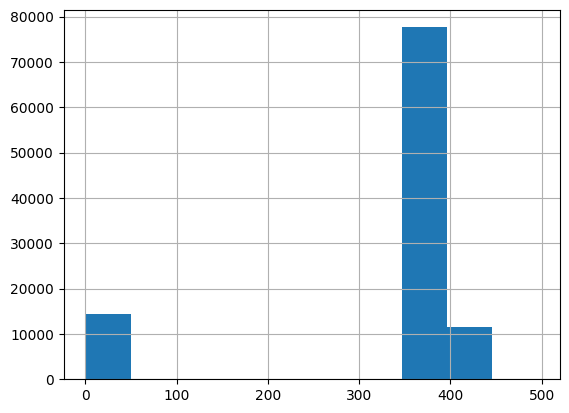

In [24]:
df_train.groupby('customer_id')['prev_activity_in_days'].max().hist()

In [25]:
DAYS_BEFORE_LAST_ACTIVITY = 400

CONTEXT_WINDOW = 365

## target
## TODO define the target better
##churn 1 

df_train[f'within_{DAYS_BEFORE_LAST_ACTIVITY}_days_of_last_activity'] =\
                df_train['date'] >=(df_train['last_activity'] - timedelta(days=DAYS_BEFORE_LAST_ACTIVITY))

df_train['churn_1'] = df_train[f'within_{DAYS_BEFORE_LAST_ACTIVITY}_days_of_last_activity']

# churn 2
df_train['prev_activity_more_than_year'] = df_train.prev_activity_in_days>365

df_train['churn_2'] = df_train.groupby("customer_id")['prev_activity_more_than_year'].cumsum()


In [26]:

# prev activity features
df_train['expanding_mean_prev_activity'] = df_train.groupby('customer_id')['prev_activity_in_days'].expanding()\
                            .mean().reset_index(level=0)['prev_activity_in_days']


df_train[f'rolling_mean_prev_activity_{CONTEXT_WINDOW}D'] = df_train.groupby('customer_id').rolling(f'{CONTEXT_WINDOW}D',on='date')\
    .mean('prev_activity_in_days').reset_index(level=0)['prev_activity_in_days']

df_train['prev_activity_larger_than_mean'] = (df_train['prev_activity_in_days']>
                                             df_train['expanding_mean_prev_activity'])


df_train['churn_3'] = df_train.groupby("customer_id")['prev_activity_larger_than_mean'].cumsum()

## activity volume



In [27]:
df_train[['date','prev_activity_in_days','expanding_mean_prev_activity']].sample(6)

,date,prev_activity_in_days,expanding_mean_prev_activity
107645,2017-04-11,1.0,23.515152
77946,2011-10-06,1.0,4.064000
82145,2020-03-16,2.0,10.564103
133511,2020-08-25,367.0,34.545455
348173,2023-05-31,1.0,1.000000
193710,2016-01-14,1.0,1.000000


# feature engineering

## extract csas and touchpoints

In [28]:
def extract_csat_scores(data:pd.DataFrame) -> pd.DataFrame:
    csat_scores_explode = pd.json_normalize(data['csat_scores'])
    csat_scores_explode.index = csat_scores_explode.index.values
    csat_scores_explode.columns = ['csat_appointment', 'csat_email', 'csat_phone', 'csat_whatsapp']

    return csat_scores_explode


def extract_touchpoints(data:pd.DataFrame) -> pd.DataFrame:
    data['touchpoints_count'] = data['touchpoints'].apply(Counter)
    touchpoints_explode = pd.json_normalize(data['touchpoints_count'])
    data.drop('touchpoints_count',axis=1,inplace=True)
    touchpoints_explode.columns = ['touchpoint_whatsapp', 'touchpoint_email', 'touchpoint_appointment', 'touchpoint_phone']
    return touchpoints_explode
    

def add_csat_and_touchpoints(data:pd.DataFrame) -> pd.DataFrame:
    
    data.reset_index(drop=True,inplace=True)
    csat_scores = extract_csat_scores(data)
    data = pd.concat([data,csat_scores],axis=1)
    #data.drop('csat_scores',axis=1,inplace=True)
    
    touchpoints_explode = extract_touchpoints(data)
    data = pd.concat([data,touchpoints_explode],axis=1)
    #data.drop('touchpoints',axis=1,inplace=True)
    return data

In [29]:
df_train = add_csat_and_touchpoints(df_train)
df_test = add_csat_and_touchpoints(df_test)

## basic features

In [30]:
real_activity_columns = ['atm_transfer_in',
       'atm_transfer_out', 'bank_transfer_in', 'bank_transfer_out',
       'crypto_in', 'crypto_out']

real_activity_volumn_columns = ['bank_transfer_in_volume',
       'bank_transfer_out_volume', 'crypto_in_volume', 'crypto_out_volume']


csat_columns = ['csat_whatsapp','csat_phone','csat_email','csat_appointment']

def add_basic_features(data:pd.DataFrame) -> pd.DataFrame:
    
    data['activities_count_today'] = data[real_activity_columns+
                                            real_activity_volumn_columns].gt(0).sum(axis=1)
    
    data['total_volume_in'] = data[[c for c in real_activity_volumn_columns 
                                    if 'in_volume' in c]].sum(axis=1)
    
    data['total_volume_out'] = data[[c for c in real_activity_volumn_columns if
                                     'out_volume' in c]].sum(axis=1)
    
    data['csat_answeres'] = data[csat_columns].count(axis=1)
    
    return data

In [31]:
%%time

df_train = add_basic_features(df_train)
df_test = add_basic_features(df_test)


CPU times: user 2.23 s, sys: 79.2 ms, total: 2.3 s
Wall time: 2.21 s


## agg features

In [32]:
rolling_mean_columns = ['atm_transfer_in', 'atm_transfer_out', 
                     'bank_transfer_in','bank_transfer_out',
                     'crypto_in','crypto_out',
                        'bank_transfer_in_volume','bank_transfer_out_volume',
                        'crypto_in_volume', 'crypto_out_volume',
                        
                       'interest_rate',
                        'activities_count_today',
                        'csat_answeres',
                        'csat_whatsapp','csat_phone','csat_email','csat_appointment'
        
                       ]

rolling_sum_columns = ['touchpoint_whatsapp', 'touchpoint_email', 'touchpoint_appointment',
       'touchpoint_phone','csat_answeres',]

rolling_count_columns = ['Id']
 
cumsum_columns = [ 'bank_transfer_in',
                     'bank_transfer_out']

new_rolling_mean_columns = [col+f'_roll_mean_{CONTEXT_WINDOW}' for col in rolling_mean_columns]
new_rolling_sum_columns = [col+f'_roll_sum_{CONTEXT_WINDOW}' for col in rolling_sum_columns]
new_rolling_count_columns = [col+f'_roll_count_{CONTEXT_WINDOW}' for col in rolling_count_columns]
new_cumsum_columns = [col+'_cumsum' for col in cumsum_columns]



In [33]:
def create_rolling_features(data:pd.DataFrame,
                            context_window:int = CONTEXT_WINDOW,
                            group_column:list[str] = ['customer_id']) -> pd.DataFrame:

    if len(group_column) == 1:
        level = 0
    else:
        level=None

    #data = data.reset_index(drop=True)
    

    data[new_rolling_mean_columns] = data.groupby(group_column).\
    rolling(f'{context_window}D',on='date')\
    .mean(rolling_mean_columns).reset_index(level=level)[rolling_mean_columns]
    
    
    data[new_rolling_sum_columns] = data.groupby(group_column).\
    rolling(f'{context_window}D',on='date')\
    .sum(rolling_sum_columns).reset_index(level=level)[rolling_sum_columns]
    
    
    data[new_rolling_count_columns] = data.groupby(group_column).\
    rolling(f'{context_window}D',on='date')\
    .count(rolling_count_columns).reset_index(level=level)[rolling_count_columns]
    

    return data


In [34]:
def create_expanding_features(data:pd.DataFrame,group_column:list[str] = ['customer_id']) -> pd.DataFrame:
    
    data[new_cumsum_columns] = data.groupby(group_column)[cumsum_columns].cumsum()
    
    data['avg_interest_rate'] = data.groupby(group_column)['interest_rate'].\
                                expanding().mean().reset_index()['interest_rate']
    
    data['min_interest_rate'] = data.groupby(group_column)['interest_rate'].\
                                expanding().min().reset_index()['interest_rate']
    
    data['max_interest_rate'] = data.groupby(group_column)['interest_rate'].\
                                expanding().max().reset_index()['interest_rate']

    return data

In [35]:
%%time 

import warnings
with warnings.catch_warnings():
    warnings.simplefilter(action='ignore', category=FutureWarning)
    

    df_train = create_rolling_features(df_train,CONTEXT_WINDOW,['customer_id','year_bin'])
    df_test = create_rolling_features(df_test)

    df_train = create_expanding_features(df_train,['customer_id','year_bin'])
    df_test = create_expanding_features(df_test)

CPU times: user 12min 8s, sys: 20.9 s, total: 12min 29s
Wall time: 12min 29s


In [36]:
CONTEXT_WINDOW = 60
new_rolling_mean_columns = [col+f'_roll_mean_{CONTEXT_WINDOW}' for col in rolling_mean_columns]
new_rolling_sum_columns = [col+f'_roll_sum_{CONTEXT_WINDOW}' for col in rolling_sum_columns]
new_rolling_count_columns = [col+f'_roll_count_{CONTEXT_WINDOW}' for col in rolling_count_columns]

In [37]:
%%time 

with warnings.catch_warnings():
    warnings.simplefilter(action='ignore', category=FutureWarning)
    

    df_train = create_rolling_features(df_train,CONTEXT_WINDOW,['customer_id','year_bin'])
    df_test = create_rolling_features(df_test)

CPU times: user 18min 47s, sys: 29.6 s, total: 19min 17s
Wall time: 19min 17s


## TODO add more features

In [38]:

churn_columns = ['days_between_first_and_last_activity','year_bin','prev_activity_more_than_year',
   'churn_2','prev_activity_larger_than_men', 'expanding_mean_prev_activity',

                 'churn_1', 'churn_3','year','first_activity','last_activity']

drop_columns = ['Id', 'customer_id','date_of_birth','name','touchpoints',
                'rolling_mean_prev_activity_365D', 'prev_activity_larger_than_mean',

                
                'address', 'date','within_365_days_of_last_activity','touchpoints','csat_scores']

fraud_columns = ['churn_due_to_fraud','model_predicted_fraud',]


target = 'within_400_days_of_last_activity'

In [39]:
cols_for_model = [c for c in df_train.columns if c not in drop_columns+churn_columns+fraud_columns+[target]]

In [40]:
# cols_for_model = ['interest_rate',
#  'country',
#  'atm_transfer_in',
#  'atm_transfer_out',
#  'bank_transfer_in',
#  'bank_transfer_out',
#  'crypto_in',
#  'crypto_out',
#  'bank_transfer_in_volume',
#  'bank_transfer_out_volume',
#  'crypto_in_volume',
#  'crypto_out_volume',
#  'complaints',
#  'tenure',
#  'from_competitor',
#  'job',
#  'month',
#  'prev_activity_in_days',
#  'activities_count_today',
#  'csat_appointment',
#  'csat_email',
#  'csat_phone',
#  'csat_whatsapp',
#  'touchpoint_whatsapp',
#  'touchpoint_email',
#  'touchpoint_appointment',
#  'touchpoint_phone',
#  'total_volume_in',
#  'total_volume_out',
#  'csat_answeres',
#  'atm_transfer_in_roll_mean_365',
#  'atm_transfer_out_roll_mean_365',
#  'bank_transfer_in_roll_mean_365',
#  'bank_transfer_out_roll_mean_365',
#  'crypto_in_roll_mean_365',
#  'crypto_out_roll_mean_365',
#  'bank_transfer_in_volume_roll_mean_365',
#  'bank_transfer_out_volume_roll_mean_365',
#  'crypto_in_volume_roll_mean_365',
#  'crypto_out_volume_roll_mean_365',
#  'interest_rate_roll_mean_365',
#  'activities_count_today_roll_mean_365',
#  'csat_answeres_roll_mean_365',
#  'csat_whatsapp_roll_mean_365',
#  'csat_phone_roll_mean_365',
#  'csat_email_roll_mean_365',
#  'csat_appointment_roll_mean_365',
#  'touchpoint_whatsapp_roll_sum_365',
#  'touchpoint_email_roll_sum_365',
#  'touchpoint_appointment_roll_sum_365',
#  'touchpoint_phone_roll_sum_365',
#  'csat_answeres_roll_sum_365',
#  'Id_roll_count_365',
#  'bank_transfer_in_cumsum',
#  'bank_transfer_out_cumsum',
#  'avg_interest_rate',
#  'min_interest_rate',
#  'max_interest_rate',
#  'atm_transfer_in_roll_mean_60',
#  'atm_transfer_out_roll_mean_60',
#  'bank_transfer_in_roll_mean_60',
#  'bank_transfer_out_roll_mean_60',
#  'crypto_in_roll_mean_60',
#  'crypto_out_roll_mean_60',
#  'bank_transfer_in_volume_roll_mean_60',
#  'bank_transfer_out_volume_roll_mean_60',
#  'crypto_in_volume_roll_mean_60',
#  'crypto_out_volume_roll_mean_60',
#  'interest_rate_roll_mean_60',
#  'activities_count_today_roll_mean_60',
#  'csat_answeres_roll_mean_60',
#  'csat_whatsapp_roll_mean_60',
#  'csat_phone_roll_mean_60',
#  'csat_email_roll_mean_60',
#  'csat_appointment_roll_mean_60',
#  'touchpoint_whatsapp_roll_sum_60',
#  'touchpoint_email_roll_sum_60',
#  'touchpoint_appointment_roll_sum_60',
#  'touchpoint_phone_roll_sum_60',
#  'csat_answeres_roll_sum_60',
#  'Id_roll_count_60']

In [41]:

categorical_columns = ['country','job']

target = 'within_400_days_of_last_activity'

# inspect 10 sample 

In [42]:
verified_target = [74330,41422,98852,41620,84714,84703,84692,3367,	41857]
verified_target_df = df_train[df_train['customer_id'].isin(verified_target)].copy()
verified_target_df['target'] = np.where(verified_target_df['customer_id']==3367,1,0)

## pca

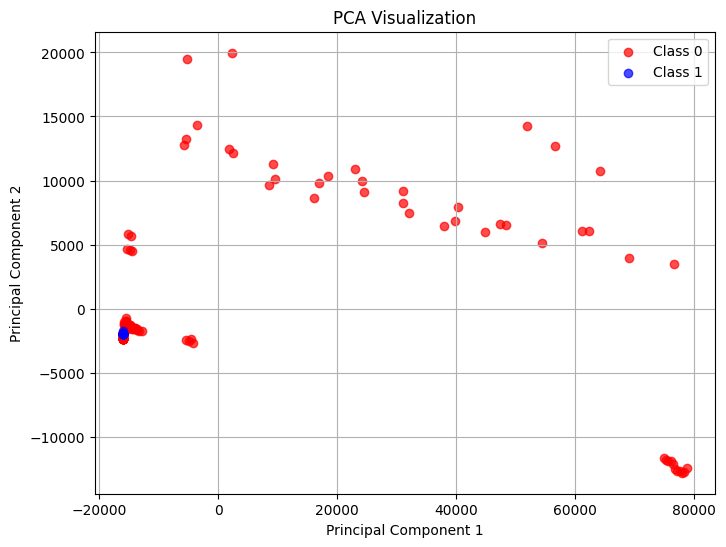

In [43]:
from sklearn.decomposition import PCA
X = verified_target_df[list(set(cols_for_model) - set(categorical_columns))].fillna(0)
y = verified_target_df['target']

# Apply PCA to reduce to 2 dimensions
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

# Create a scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(
    X_pca[y == 0, 0], X_pca[y == 0, 1], color='red', label='Class 0', alpha=0.7
)
plt.scatter(
    X_pca[y == 1, 0], X_pca[y == 1, 1], color='blue', label='Class 1', alpha=0.7
)
plt.title("PCA Visualization")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend()
plt.grid(True)
plt.show()

## tsne

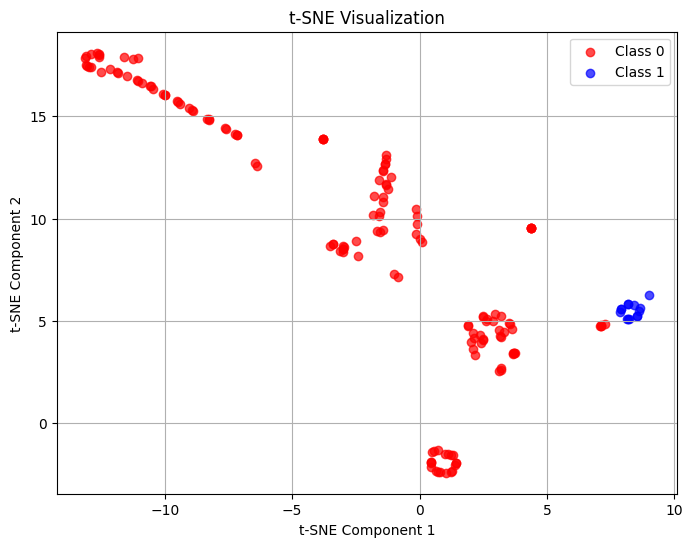

In [44]:
from sklearn.manifold import TSNE

X = verified_target_df[list(set(cols_for_model) - set(categorical_columns))].fillna(0)
y = verified_target_df['target']

# Apply t-SNE to reduce to 2 dimensions
tsne = TSNE(n_components=2, random_state=42, perplexity=30, learning_rate=200)
X_tsne = tsne.fit_transform(X)

# Create a scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(
    X_tsne[y == 0, 0], X_tsne[y == 0, 1], color='red', label='Class 0', alpha=0.7
)
plt.scatter(
    X_tsne[y == 1, 0], X_tsne[y == 1, 1], color='blue', label='Class 1', alpha=0.7
)
plt.title("t-SNE Visualization")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.legend()
plt.grid(True)
plt.show()

# autoencoders

## find non churners

In [45]:
## more conservative non churners

real_activities_only = df_train[(df_train['year']<=2023) & 
                                (df_train['activities_count_today'] > 0)].copy()

real_activities_only['max_year'] = real_activities_only.groupby('customer_id')['year'].\
                                                                    transform('max')


In [46]:
real_activities_only.shape

(3926058, 105)

In [47]:
df_non_churners = real_activities_only[(real_activities_only['max_year']>=2023) &
                                        (real_activities_only['year']<2022) &
                                        (real_activities_only['churn_3']==0)]


# df_non_churners = real_activities_only[(real_activities_only['max_year']>=2023) &
#                                         (real_activities_only['year']<2022)]
# ## to do add 

In [48]:
#!pip install --upgrade tensorflow==2.13
import tensorflow as tf

In [49]:
tf.__version__

'2.17.0'

In [50]:
%%time
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.preprocessing import MinMaxScaler




## TODO handle missing values 
X = df_non_churners[[c for c in cols_for_model if (c!='country') & (c!='job')]].fillna(0)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=X.columns)

X_train, X_val = train_test_split(X_scaled, test_size=0.2, random_state=17)

input_dim = X_train.shape[1]
N = 2

input_layer = Input(shape=(input_dim,))
encoded = Dense(32*N, activation='relu')(input_layer)

#encoded = Dense(24*N, activation='relu')(encoded)

encoded = Dense(16*N, activation='relu')(encoded)
encoded = Dense(8*N, activation='relu')(encoded)

encoded = Dense(4*N, activation='relu')(encoded)
decoded = Dense(8*N, activation='relu')(encoded)

decoded = Dense(16*N, activation='relu')(decoded)
#decoded = Dense(24*N, activation='relu')(decoded)
decoded = Dense(32*N, activation='relu')(decoded)
decoded = Dense(input_dim, activation='sigmoid')(decoded)

autoencoder = Model(input_layer, decoded, name='neo_bank_churn')
autoencoder.compile(optimizer='adam', loss='mse')

model_name = "neo_bank_churn.weights.h5"
checkpoint = ModelCheckpoint(model_name,
                            monitor="val_loss",
                            mode="min",
                            save_best_only = True,
                            save_weights_only=True,
                            verbose=1)
earlystopping = EarlyStopping(monitor='val_loss',
                              min_delta = 0, 
                              patience = 5, 
                              verbose = 1,
                              restore_best_weights=True)

callbacks = [checkpoint, earlystopping]




history = autoencoder.fit(
    X_train, X_train,
    epochs=100*5,
    batch_size=512*1,
    validation_data=(X_val, X_val),
    verbose=1,callbacks=callbacks, shuffle=True
)



X_val_reconstructed = autoencoder.predict(X_val)
reconstruction_errors = np.mean(np.square(X_val - X_val_reconstructed), axis=1)
print(reconstruction_errors.mean())

Epoch 1/500
565/565 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.8874
Epoch 1: val_loss improved from inf to 0.71132, saving model to neo_bank_churn.weights.h5
565/565 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - loss: 0.8872 - val_loss: 0.7113
Epoch 2/500
558/565 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7195
Epoch 2: val_loss improved from 0.71132 to 0.68603, saving model to neo_bank_churn.weights.h5
565/565 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.7193 - val_loss: 0.6860
Epoch 3/500
554/565 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6840
Epoch 3: val_loss improved from 0.68603 to 0.67694, saving model to neo_bank_churn.weights.h5
565/565 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6841 - val_loss: 0.6769
Epoch 4/500
539/565 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6754
Epoch 4: val_loss improved from 0.67694 to 0.67309, saving model to neo_bank_churn.weights.h5
565/565 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6757 - val_loss: 0.6731
Epoch 5/500
544/565 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - l

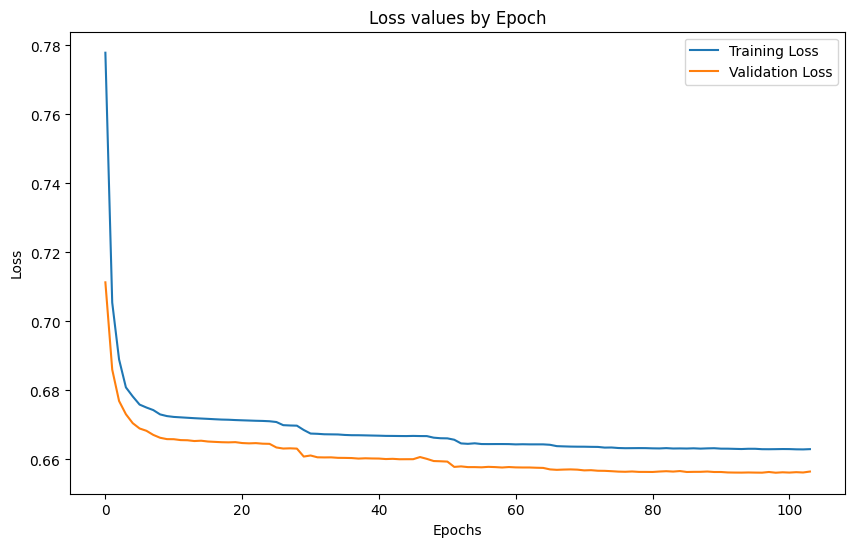

In [51]:
plt.figure(figsize=(10,6))
plt.plot(history.history['loss'], label="Training Loss")
plt.plot(history.history['val_loss'], label="Validation Loss")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title("Loss values by Epoch")
plt.show()

In [52]:
# from scipy.stats import norm

# mean, std = norm.fit(reconstruction_errors)
# cdf = norm.cdf(reconstruction_errors, loc=mean, scale=std)
# anomaly_probabilities = 1 - cdf

# print("Reconstruction errors:", reconstruction_errors[:5])
# print("Anomaly probabilities:", anomaly_probabilities[:5])
#anomaly_probabilities.mean()

# from statsmodels.distributions.empirical_distribution import ECDF

# ecdf = ECDF(reconstruction_errors)
# reconstruction_errors_normalized = 1 - ecdf(reconstruction_errors)
# reconstruction_errors_normalized.mean()


# from scipy.stats import lognorm
# shape, loc, scale = lognorm.fit(reconstruction_errors, floc=0)
# cdf = lognorm.cdf(reconstruction_errors, s=shape, loc=loc, scale=scale)
# reconstruction_errors_normalized = 1 - cdf

# reconstruction_errors_normalized.mean()

In [53]:
prob_scaler = MinMaxScaler()
reconstruction_errors_normalized = prob_scaler.fit_transform(reconstruction_errors.values.reshape(-1, 1))
reconstruction_errors_normalized.mean()

0.0024727096309873774

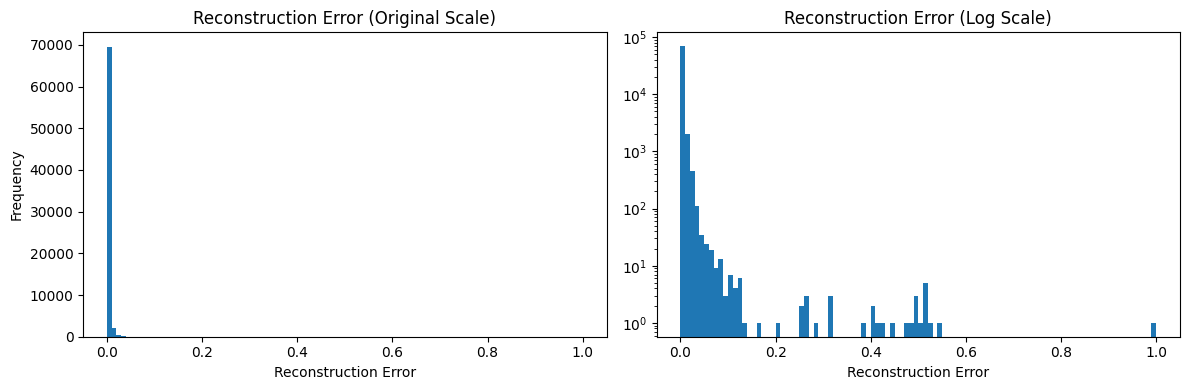

In [54]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

ax1.hist(reconstruction_errors_normalized, bins=100)
ax1.set_title("Reconstruction Error (Original Scale)")
ax1.set_xlabel("Reconstruction Error")
ax1.set_ylabel("Frequency")

ax2.hist(reconstruction_errors_normalized, bins=100)
ax2.set_title("Reconstruction Error (Log Scale)")
ax2.set_xlabel("Reconstruction Error")
ax2.set_yscale("log")  

plt.tight_layout()
plt.show()

## create prediction 

In [55]:

df_pred = df_test[X.columns].fillna(0)
X_new = scaler.transform(df_pred)

new_reconstruction_errors = np.mean(np.square(X_new - autoencoder.predict(X_new)), axis=1)
new_churn_probabilities = prob_scaler.transform(new_reconstruction_errors.reshape(-1, 1))

for i, prob in enumerate(new_churn_probabilities[:10]):  
    print(f"Customer {i+1}: Churn Probability = {prob[0]:.2f}")

42515/42515 ━━━━━━━━━━━━━━━━━━━━ 51s 1ms/step
Customer 1: Churn Probability = 0.12
Customer 2: Churn Probability = 0.01
Customer 3: Churn Probability = 1.98
Customer 4: Churn Probability = 0.01
Customer 5: Churn Probability = 0.18
Customer 6: Churn Probability = 0.15
Customer 7: Churn Probability = 0.16
Customer 8: Churn Probability = 0.15
Customer 9: Churn Probability = 0.15
Customer 10: Churn Probability = 0.15


In [56]:
new_churn_probabilities[0:15]

array([[0.11666567],
       [0.00940364],
       [1.9805276 ],
       [0.00981115],
       [0.1844304 ],
       [0.14601785],
       [0.15914725],
       [0.15240069],
       [0.1524273 ],
       [0.15232871],
       [0.15240741],
       [0.15236507],
       [0.01302146],
       [0.0234372 ],
       [0.00834805]])

In [57]:
new_churn_probabilities.mean()

0.016617675023618484

In [58]:
sub = df_test['Id'].copy().reset_index()
sub['churn'] = new_churn_probabilities.reshape(1360472,).tolist()
sub.churn = sub.churn.clip(upper=1)
sub[['Id','churn']].set_index('Id').to_csv('submission.csv')

<a href="submission.csv"> Download File </a>